Transfer from text_classifier4, and use title data. The text_classifier4 is:
- Used the pre-trained glove embedding model in this trial.
- Add Convolution layers.
- Change tanh to sigmoid

In [29]:
import read_data 
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Bidirectional
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.models import load_model
from keras.callbacks import ModelCheckpoint, TensorBoard, CSVLogger
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from pandas.io.pickle import to_pickle, read_pickle
save_dir = 'title_classifier1/'
import os
if not os.path.exists(save_dir):
    os.mkdir(save_dir)

In [30]:
#%% imbeding vectors
#download
glove_dir = 'glove_data/'
if not os.path.exists(glove_dir):
    os.mkdir(glove_dir)
if not os.path.exists(glove_dir+'glove.6B.zip'):
    import subprocess
    subprocess.run(["wget",'-P'+glove_dir, "http://nlp.stanford.edu/data/glove.6B.zip"])
    print('downloaded')
if not os.path.exists(glove_dir+'glove.6B.100d.txt'):
    import zipfile
    zip_ref = zipfile.ZipFile(glove_dir+'glove.6B.zip', 'r')
    zip_ref.extractall(glove_dir)
    zip_ref.close()
    print('unziped')

In [31]:
embeddings_index = {}
with open(glove_dir+'glove.6B.50d.txt') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [32]:
#%% first steps
books,genre,_ = read_data.read_text_data()
id_train,id_val = read_data.read_ids()
books.head()

,author,title1,title2,url,imgurl
137843412,Allegra Goodman,The Cookbook Collector,NaN,http://www.npr.org/books/titles/137843412/the-...,https://media.npr.org/assets/bakertaylor/cover...
137845249,Keith Devlin,The Man of Numbers,Fibonacci's Arithmetic Revolution,http://www.npr.org/books/titles/137845249/the-...,https://media.npr.org/assets/bakertaylor/cover...
137847611,Alice LaPlante,Turn of Mind,NaN,http://www.npr.org/books/titles/137847611/turn...,https://media.npr.org/assets/bakertaylor/cover...
137854248,Don Tapscott,Macrowikinomics,New Solutions for a Connected Planet,http://www.npr.org/books/titles/137854248/macr...,https://media.npr.org/assets/bakertaylor/cover...
137864044,Lev Grossman,The Magicians,A Novel,http://www.npr.org/books/titles/137864044/the-...,https://media.npr.org/assets/bakertaylor/cover...


In [33]:
def combine_title(ts):
    t=''
    t1,t2 = list(ts)
    if not pd.isna(t1): t+=t1
    if not pd.isna(t2): t+=t2
    return t
titles = {id:combine_title(books.loc[id,['title1','title2']]) for id in books.index}
titles = {str(int(id)):t for id,t in titles.items()}


In [35]:
MAX_WORDS = 8000
tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(titles.values())
sequences = tokenizer.texts_to_sequences(titles.values())

word_index = tokenizer.word_index
to_pickle(tokenizer, save_dir+'text_tokenizer.pickle')
print(len(word_index))
list(word_index.items())[:10]

15673


[('moneywasted', 4924),
 ('tropical', 4699),
 ('roundsa', 11703),
 ('meatless', 3449),
 ('larathe', 8333),
 ('blocwords', 13928),
 ('flavorsthe', 9214),
 ('moirecipes', 14296),
 ('adaptation', 1808),
 ('diet', 1273)]

(0, 50)

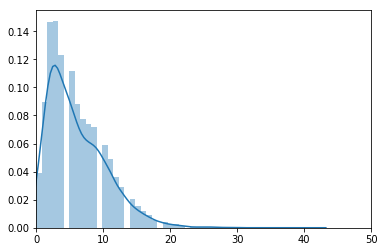

In [36]:
lens = [len(s) for s in sequences]
sns.distplot(lens)
plt.xlim((0,50))

In [37]:
MAXLEN = 50
data = pad_sequences(sequences, maxlen=MAXLEN)

#labels = to_categorical(np.asarray(labels))
labels = ['Fiction' in genre[id] for id in titles.keys()]
labels = np.array(labels).reshape((-1,1))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Shape of data tensor: (9800, 50)
Shape of label tensor: (9800, 1)


In [38]:
# split the data into a training set and a validation set

train_index = [id in id_train for id in titles.keys()]
val_index = [id in id_val for id in titles.keys()]
x_train = data[train_index]
y_train = labels[train_index]
x_val = data[val_index]
y_val = labels[val_index]
print(x_train.shape,y_train.shape,x_val.shape,y_val.shape)

to_pickle((x_train, y_train, x_val, y_val),save_dir+'text_dataset.pc')

(6860, 50) (6860, 1) (2940, 50) (2940, 1)


In [39]:
# prepare embedding layer
embedding_vecor_length = 50 # this is determined by the glove data!!!
num_words = min(MAX_WORDS, len(word_index))
embedding_matrix = np.zeros((num_words, embedding_vecor_length))
for word, i in word_index.items():
    if i >= MAX_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

embedding_layer = Embedding(num_words,
                            embedding_vecor_length,
                            weights=[embedding_matrix],
                            input_length=MAXLEN,
                            trainable=False)

In [40]:

model = Sequential()
model.add(embedding_layer)
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(64,dropout=0.2, recurrent_dropout=0.2)))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

checkpoint = ModelCheckpoint(save_dir+"text_best_model.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
#early = EarlyStopping(monitor='val_acc', min_delta=0, patience=10, verbose=1, mode='auto')
with open(save_dir+'text_csvlogger.csv','w') as f:
    f.write('')
csvlog = CSVLogger(save_dir+'text_csvlogger.csv',append=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 50, 50)            400000    
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 48, 64)            9664      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 24, 64)            0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 128)               66048     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 475,841
Trainable params: 75,841
Non-trainable params: 400,000
_________________________________________________________________
None


In [41]:
model.fit(x_train, y_train, epochs=50, batch_size=64,
          callbacks = [checkpoint, csvlog],
          validation_data=(x_val, y_val))

#scores = model.evaluate(x_val, y_val, verbose=0)
#print("Accuracy: %f%%" % (scores[1]*100))

model.save(save_dir+'text_last_model.h5')
print(checkpoint.best)

Train on 6860 samples, validate on 2940 samples
Epoch 1/50
6860/6860 [==============================] - 9s - loss: 0.4791 - acc: 0.7439 - val_loss: 0.3962 - val_acc: 0.8116
Epoch 2/50
6860/6860 [==============================] - 8s - loss: 0.4013 - acc: 0.8171 - val_loss: 0.3849 - val_acc: 0.8170
Epoch 3/50
6860/6860 [==============================] - 8s - loss: 0.3751 - acc: 0.8273 - val_loss: 0.3818 - val_acc: 0.8235
Epoch 4/50
6860/6860 [==============================] - 8s - loss: 0.3582 - acc: 0.8382 - val_loss: 0.3774 - val_acc: 0.8252
Epoch 5/50
6860/6860 [==============================] - 8s - loss: 0.3404 - acc: 0.8478 - val_loss: 0.3796 - val_acc: 0.8252
Epoch 6/50
6860/6860 [==============================] - 8s - loss: 0.3294 - acc: 0.8534 - val_loss: 0.3787 - val_acc: 0.8177
Epoch 7/50
6860/6860 [==============================] - 8s - loss: 0.3096 - acc: 0.8628 - val_loss: 0.3885 - val_acc: 0.8245
Epoch 8/50
6860/6860 [==============================] - 8s - loss: 0.2951 - a

6860/6860 [==============================] - 8s - loss: 0.1132 - acc: 0.9539 - val_loss: 0.7529 - val_acc: 0.8129
Epoch 34/50
6860/6860 [==============================] - 8s - loss: 0.1126 - acc: 0.9569 - val_loss: 0.7489 - val_acc: 0.8082
Epoch 35/50
6860/6860 [==============================] - 8s - loss: 0.1063 - acc: 0.9586 - val_loss: 0.7927 - val_acc: 0.8173
Epoch 36/50
6860/6860 [==============================] - 8s - loss: 0.1062 - acc: 0.9566 - val_loss: 0.7315 - val_acc: 0.8109
Epoch 37/50
6860/6860 [==============================] - 8s - loss: 0.1029 - acc: 0.9608 - val_loss: 0.7793 - val_acc: 0.8139
Epoch 38/50
6860/6860 [==============================] - 8s - loss: 0.0942 - acc: 0.9628 - val_loss: 0.7744 - val_acc: 0.8075
Epoch 39/50
6860/6860 [==============================] - 8s - loss: 0.0945 - acc: 0.9612 - val_loss: 0.7892 - val_acc: 0.8058
Epoch 40/50
6860/6860 [==============================] - 8s - loss: 0.0934 - acc: 0.9647 - val_loss: 0.8245 - val_acc: 0.8102
Epoc

In [42]:
#%% continue training

#model = load_model(save_dir+'text_last_model.h5')
#x_train, y_train, x_val, y_val = read_pickle(save_dir+'text_dataset.pc')

model.fit(x_train, y_train, epochs=100, batch_size=64,
          callbacks = [checkpoint, csvlog],
          validation_data=(x_val, y_val))

model.save(save_dir+'text_last_model.h5')
print(checkpoint.best)

Train on 6860 samples, validate on 2940 samples
Epoch 1/100
6860/6860 [==============================] - 8s - loss: 0.0735 - acc: 0.9691 - val_loss: 0.9214 - val_acc: 0.8048
Epoch 2/100
6860/6860 [==============================] - 8s - loss: 0.0810 - acc: 0.9692 - val_loss: 0.9309 - val_acc: 0.8153
Epoch 3/100
6860/6860 [==============================] - 8s - loss: 0.0717 - acc: 0.9704 - val_loss: 0.9321 - val_acc: 0.8068
Epoch 4/100
6860/6860 [==============================] - 8s - loss: 0.0747 - acc: 0.9704 - val_loss: 0.9473 - val_acc: 0.8014
Epoch 5/100
6860/6860 [==============================] - 8s - loss: 0.0710 - acc: 0.9724 - val_loss: 1.0430 - val_acc: 0.8126
Epoch 6/100
6860/6860 [==============================] - 8s - loss: 0.0761 - acc: 0.9710 - val_loss: 0.9922 - val_acc: 0.8024
Epoch 7/100
6860/6860 [==============================] - 8s - loss: 0.0706 - acc: 0.9708 - val_loss: 0.9786 - val_acc: 0.8058
Epoch 8/100
6860/6860 [==============================] - 8s - loss: 0.

6860/6860 [==============================] - 8s - loss: 0.0572 - acc: 0.9774 - val_loss: 1.1978 - val_acc: 0.8037
Epoch 35/100
6860/6860 [==============================] - 8s - loss: 0.0574 - acc: 0.9767 - val_loss: 1.2243 - val_acc: 0.8058
Epoch 36/100
6860/6860 [==============================] - 8s - loss: 0.0586 - acc: 0.9774 - val_loss: 1.1734 - val_acc: 0.8044
Epoch 37/100
6860/6860 [==============================] - 8s - loss: 0.0580 - acc: 0.9758 - val_loss: 1.1881 - val_acc: 0.8061
Epoch 38/100
6860/6860 [==============================] - 8s - loss: 0.0602 - acc: 0.9762 - val_loss: 1.2093 - val_acc: 0.8034
Epoch 39/100
6860/6860 [==============================] - 8s - loss: 0.0609 - acc: 0.9765 - val_loss: 1.1679 - val_acc: 0.8126
Epoch 40/100
6860/6860 [==============================] - 8s - loss: 0.0563 - acc: 0.9777 - val_loss: 1.2453 - val_acc: 0.8078
Epoch 41/100
6860/6860 [==============================] - 8s - loss: 0.0551 - acc: 0.9781 - val_loss: 1.2182 - val_acc: 0.80

6860/6860 [==============================] - 8s - loss: 0.0490 - acc: 0.9793 - val_loss: 1.2496 - val_acc: 0.8071
Epoch 68/100
6860/6860 [==============================] - 8s - loss: 0.0489 - acc: 0.9797 - val_loss: 1.3266 - val_acc: 0.8071
Epoch 69/100
6860/6860 [==============================] - 8s - loss: 0.0502 - acc: 0.9802 - val_loss: 1.2970 - val_acc: 0.8068
Epoch 70/100
6860/6860 [==============================] - 8s - loss: 0.0527 - acc: 0.9794 - val_loss: 1.2620 - val_acc: 0.8037
Epoch 71/100
6860/6860 [==============================] - 8s - loss: 0.0483 - acc: 0.9799 - val_loss: 1.3068 - val_acc: 0.8075
Epoch 72/100
6860/6860 [==============================] - 8s - loss: 0.0438 - acc: 0.9818 - val_loss: 1.3465 - val_acc: 0.8071
Epoch 73/100
6860/6860 [==============================] - 8s - loss: 0.0436 - acc: 0.9815 - val_loss: 1.3515 - val_acc: 0.8129
Epoch 74/100
6860/6860 [==============================] - 8s - loss: 0.0496 - acc: 0.9793 - val_loss: 1.2945 - val_acc: 0.80

6860/6860 [==============================] - 8s - loss: 0.0471 - acc: 0.9809 - val_loss: 1.3632 - val_acc: 0.8048
0.825170067946
